In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from dataprep.clean import clean_country
from plotly.subplots import make_subplots
import dask.dataframe as dd

In [2]:
co2_file_path = "./dataset/owid-co2-data.csv"
co2_df = pd.read_csv(co2_file_path)

In [3]:
# dask is cool with huge csvs
csv_file_path = "/home/amir/big_storage/datasets/IHME-GDB-Risk-all.csv"

risk_df= pd.read_csv(csv_file_path)
risk_df = clean_country(risk_df, 'location', output_format='alpha-3')

  0%|          | 0/91 [00:00<?, ?it/s]

Country Cleaning Report:
	2741220 values cleaned (99.37%)
	17460 values unable to be parsed (0.63%), set to NaN
Result contains 2741220 (99.37%) values in the correct format and 17460 null values (0.63%)


In [4]:
risk_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,YLDs,Norway,Male,All Ages,Depressive disorders,All risk factors,Number,1992,576.937291,1074.430283,241.176114,NOR
1,YLDs,Norway,Female,All Ages,Depressive disorders,All risk factors,Number,1992,1831.591888,3294.474095,665.732721,NOR
2,YLDs,Norway,Both,All Ages,Depressive disorders,All risk factors,Number,1992,2408.529178,4122.109930,974.516636,NOR
3,YLDs,Norway,Male,All Ages,Depressive disorders,All risk factors,Rate,1992,27.241200,50.731285,11.387593,NOR
4,YLDs,Norway,Female,All Ages,Depressive disorders,All risk factors,Rate,1992,84.472852,151.940847,30.703533,NOR


In [5]:
cause_list = [
    "Depressive disorders",
    "Cardiovascular diseases",
    "Chronic respiratory diseases",
    "Neurological disorders",
    "Tracheal, bronchus, and lung cancer",
    "Stomach cancer",
    "Pancreatic cancer",
    "Leukemia",
    "Esophageal cancer",
    "Larynx cancer",
    "Colon and rectum cancer",
    "Liver cancer",
    "Other non-communicable diseases",
]

# cause_list = [
#     "All causes"
# ]


In [6]:

cause_df = risk_df[
    risk_df.cause.isin(cause_list)
    & (risk_df.metric == "Rate")
    & (risk_df.measure == "Deaths")
    & (risk_df.sex == "Both")
    # & (risk_df.year >= 2000)
].sort_values("year").reset_index(drop=True)
cause_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,Lao People's Democratic Republic,Both,All Ages,Stomach cancer,All risk factors,Rate,1990,2.141225,3.986941,1.197598,LAO
1,Deaths,Lao People's Democratic Republic,Both,All Ages,Neurological disorders,All risk factors,Rate,1990,1.201337,3.796150,0.166485,LAO
2,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Particulate matter pollution,Rate,1990,0.015407,0.045529,0.002352,OMN
3,Deaths,Oman,Both,All Ages,Other non-communicable diseases,All risk factors,Rate,1990,0.071865,0.185637,0.012971,OMN
4,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Air pollution,Rate,1990,0.015407,0.045529,0.002352,OMN


In [7]:
co2_df = co2_df[co2_df.year.between(cause_df.year.min(), cause_df.year.max())]
co2_df[co2_df.iso_code=="USA"]

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
24037,USA,United States,1990,5113.455,5031.786,-0.36,-18.472,-81.669,20.282,19.958,...,22.488,798.61,3.168,254.99,1.011,252120309.0,9.250378e+12,22498.158,89235.912,2.432
24038,USA,United States,1991,5057.931,4949.136,-1.09,-55.524,-108.795,19.871,19.444,...,22.110,801.89,3.150,256.20,1.007,254539371.0,9.243499e+12,22466.677,88264.181,2.431
24039,USA,United States,1992,5167.481,5134.515,2.17,109.550,-32.966,20.108,19.979,...,22.215,800.73,3.116,261.95,1.019,256990608.0,9.572148e+12,22803.378,88732.202,2.383
24040,USA,United States,1993,5267.343,5194.300,1.93,99.862,-73.043,20.296,20.014,...,22.422,783.55,3.019,269.35,1.038,259532130.0,9.834941e+12,23279.396,89697.594,2.366
24041,USA,United States,1994,5358.824,5295.360,1.74,91.481,-63.464,20.435,20.193,...,22.522,790.58,3.015,273.36,1.042,262241204.0,1.023202e+13,23712.755,90423.527,2.325
24042,USA,United States,1995,5421.502,5356.474,1.17,62.678,-65.028,20.446,20.201,...,22.517,777.91,2.934,278.99,1.052,265163740.0,1.051026e+13,24222.295,91348.356,2.307
24043,USA,United States,1996,5610.582,5526.463,3.49,189.079,-84.119,20.909,20.595,...,22.618,754.68,2.812,282.97,1.055,268335007.0,1.090917e+13,25035.434,93299.171,2.297
24044,USA,United States,1997,5686.465,5632.188,1.35,75.883,-54.277,20.928,20.728,...,23.196,734.60,2.704,275.64,1.014,271713634.0,1.139876e+13,25225.640,92838.946,2.213
24045,USA,United States,1998,5731.050,5795.627,0.78,44.585,64.578,20.827,21.062,...,23.060,717.39,2.607,272.74,0.991,275175309.0,1.190603e+13,25391.342,92273.429,2.134
24046,USA,United States,1999,5804.669,5961.355,1.28,73.619,156.686,20.839,21.402,...,22.853,708.26,2.543,268.40,0.964,278548148.0,1.246382e+13,25840.805,92769.666,2.067


In [8]:
def get_all_vs_air(df, cause=None):
    result_df = [
        df,  # all
        df,  # air
    ]
    for index, poll in enumerate(["All risk factors", "Air pollution"]):
        temp = result_df[index]
        temp = temp[temp.rei == poll]
        if cause:
            temp = temp[temp.cause == cause]
        result_df[index] = temp
    # air_global_df = global_df[global_df.rei == ]
    # all_global_df = global_df[global_df.rei == ]
    
    for index, temp_df in enumerate(result_df):

        result_df[index] = temp_df.groupby("year").agg(
            val = ('val', 'sum')
        ).reset_index()

    return result_df


In [38]:
specific_cases = [
    None, # scan all
    "Chronic respiratory diseases",
    "Cardiovascular diseases",
]

In [268]:
# fig = px.line(air_global_df, x="year", y="val")
# Create tracesfrom plotly.subplots import make_subplots
def draw_plot(df, co2, where):
    fig = make_subplots(
        rows=len(specific_cases)+1, cols=1, shared_xaxes=True, x_title="year", y_title="Rate (per 100,000)",
        subplot_titles=[i if i else "All Causes" for i in specific_cases] + ["Co2 per Capita"],
    )
    # fig = go.Figure()

    for row, cause in enumerate(specific_cases):
        all_risk_df, air_risk_df = get_all_vs_air(df, cause)

        fig.add_trace(
            go.Scatter(
                x=all_risk_df.year,
                y=all_risk_df.val,
                mode="lines",
                name="All Risk Factor",
            ),
            row=row + 1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=air_risk_df.year,
                y=air_risk_df.val,
                mode="lines",
                name="Air Pollution",
            ),
            row=row + 1,
            col=1,
        )
    last_row = len(specific_cases)+1

    fig.add_trace(
        go.Scatter(
            x=co2.year,
            y=co2.co2_per_capita,
            mode="lines",
            name="co2 per capita",
        ),

        row=last_row,
        col=1,
    )

    fig.update_yaxes(title_text="Ton per capita", row=last_row, col=1)
    fig.update_layout(
        title=f"Compare Death rate for <b>All Risk Factor</b> vs <b>Air Pollution</b> over the years 1990 to 2019<br>{where}",
        legend_title="Risk Factor",
        height=700
    )
    fig["layout"]["hovermode"] = "x"
    fig.write_html(f"predict-{where}-chart.html")
    return fig


In [270]:
global_df = cause_df[cause_df.location == "Global"]
co2_world = co2_df[co2_df.country=="World"]
fig = draw_plot(global_df, co2_world, "Global" )
fig.show()

In [271]:
china_df = cause_df[cause_df.location_clean=="CHN"]
co2 = co2_df[co2_df.iso_code=="CHN"]
draw_plot(china_df,co2, where="China")

In [272]:

iran_df = cause_df[cause_df.location_clean=="IRN"]
co2 = co2_df[co2_df.iso_code=="IRN"]
draw_plot(iran_df, co2, "Iran")

In [273]:

df = cause_df[cause_df.location_clean=="IND"]
co2 = co2_df[co2_df.iso_code=="IND"]
draw_plot(iran_df, co2, "India")

In [274]:

iso_code = "USA"
df = cause_df[cause_df.location_clean=="USA"]
co2 = co2_df[co2_df.iso_code=="USA"]
draw_plot(iran_df, co2, iso_code)

In [275]:
co2

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
24037,USA,United States,1990,5113.455,5031.786,-0.36,-18.472,-81.669,20.282,19.958,...,22.488,798.61,3.168,254.99,1.011,252120309.0,9.250378e+12,22498.158,89235.912,2.432
24038,USA,United States,1991,5057.931,4949.136,-1.09,-55.524,-108.795,19.871,19.444,...,22.110,801.89,3.150,256.20,1.007,254539371.0,9.243499e+12,22466.677,88264.181,2.431
24039,USA,United States,1992,5167.481,5134.515,2.17,109.550,-32.966,20.108,19.979,...,22.215,800.73,3.116,261.95,1.019,256990608.0,9.572148e+12,22803.378,88732.202,2.383
24040,USA,United States,1993,5267.343,5194.300,1.93,99.862,-73.043,20.296,20.014,...,22.422,783.55,3.019,269.35,1.038,259532130.0,9.834941e+12,23279.396,89697.594,2.366
24041,USA,United States,1994,5358.824,5295.360,1.74,91.481,-63.464,20.435,20.193,...,22.522,790.58,3.015,273.36,1.042,262241204.0,1.023202e+13,23712.755,90423.527,2.325
24042,USA,United States,1995,5421.502,5356.474,1.17,62.678,-65.028,20.446,20.201,...,22.517,777.91,2.934,278.99,1.052,265163740.0,1.051026e+13,24222.295,91348.356,2.307
24043,USA,United States,1996,5610.582,5526.463,3.49,189.079,-84.119,20.909,20.595,...,22.618,754.68,2.812,282.97,1.055,268335007.0,1.090917e+13,25035.434,93299.171,2.297
24044,USA,United States,1997,5686.465,5632.188,1.35,75.883,-54.277,20.928,20.728,...,23.196,734.60,2.704,275.64,1.014,271713634.0,1.139876e+13,25225.640,92838.946,2.213
24045,USA,United States,1998,5731.050,5795.627,0.78,44.585,64.578,20.827,21.062,...,23.060,717.39,2.607,272.74,0.991,275175309.0,1.190603e+13,25391.342,92273.429,2.134
24046,USA,United States,1999,5804.669,5961.355,1.28,73.619,156.686,20.839,21.402,...,22.853,708.26,2.543,268.40,0.964,278548148.0,1.246382e+13,25840.805,92769.666,2.067


In [52]:
cause_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,Lao People's Democratic Republic,Both,All Ages,Stomach cancer,All risk factors,Rate,1990,2.141225,3.986941,1.197598,LAO
1,Deaths,Lao People's Democratic Republic,Both,All Ages,Neurological disorders,All risk factors,Rate,1990,1.201337,3.796150,0.166485,LAO
2,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Particulate matter pollution,Rate,1990,0.015407,0.045529,0.002352,OMN
3,Deaths,Oman,Both,All Ages,Other non-communicable diseases,All risk factors,Rate,1990,0.071865,0.185637,0.012971,OMN
4,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Air pollution,Rate,1990,0.015407,0.045529,0.002352,OMN


In [53]:
x = cause_df[cause_df.rei=="Air pollution"].groupby(['location_clean', 'year']).agg(
    val=('val', 'mean')
).reset_index()
x = x.rename({"location_clean": "iso_code"}, axis=1)
x.head()

,iso_code,year,val
0,AFG,1990,42.032542
1,AFG,1991,38.573435
2,AFG,1992,34.110325
3,AFG,1993,31.944524
4,AFG,1994,31.411907


In [54]:
co2_to_merge = co2_df[["iso_code","year", "co2_per_capita"]]

In [55]:
pm25 = pd.read_csv("./dataset/pollution_pm25.csv")
ozone = pd.read_csv("./dataset/pollution_ozone.csv")

In [56]:
pm25 = pm25[pm25.Type=="country"].rename({"ISO3": "iso_code", "Year": "year", "Exposure Mean": "pm25_exposure"}, axis=1)
pm25 = pm25[['iso_code', 'year', 'pm25_exposure']] 
pm25.head()

,iso_code,year,pm25_exposure
0,AFG,1990,49.3
1,AFG,1995,48.6
2,AFG,2000,51.6
3,AFG,2005,46.2
4,AFG,2010,51.8


In [57]:
ozone = ozone[ozone.Type=="country"].rename({"ISO3": "iso_code", "Year": "year", "Exposure Mean": "ozone_exposure"}, axis=1)
ozone = ozone[['iso_code', 'year', 'ozone_exposure']]
ozone.head()

,iso_code,year,ozone_exposure
0,AFG,1990,56.6
1,AFG,1995,54.7
2,AFG,2000,56.3
3,AFG,2005,53.6
4,AFG,2010,53.0


In [58]:
poll = pd.merge(pm25, ozone, on=['iso_code', 'year'])
poll.head()

,iso_code,year,pm25_exposure,ozone_exposure
0,AFG,1990,49.3,56.6
1,AFG,1995,48.6,54.7
2,AFG,2000,51.6,56.3
3,AFG,2005,46.2,53.6
4,AFG,2010,51.8,53.0


In [59]:
fossil = pd.read_csv('./dataset/fossil-fuel-consumption-per-capita.csv')
fossil.head()

,Entity,Code,Year,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,Africa,NaN,1965,1010.462,1017.972,29.811
1,Africa,NaN,1966,984.358,1086.678,32.505
2,Africa,NaN,1967,981.169,1051.101,31.327
3,Africa,NaN,1968,994.883,1081.425,30.957
4,Africa,NaN,1969,978.624,1068.662,35.267


In [60]:
fossil = fossil.rename({"Code": "iso_code", "Year": "year"}, axis=1).drop("Entity", axis=1)
fossil.head()

,iso_code,year,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,NaN,1965,1010.462,1017.972,29.811
1,NaN,1966,984.358,1086.678,32.505
2,NaN,1967,981.169,1051.101,31.327
3,NaN,1968,994.883,1081.425,30.957
4,NaN,1969,978.624,1068.662,35.267


In [61]:
poll = pd.merge(poll, fossil, on=['iso_code', 'year'])

In [62]:
# dataset = pd.merge(x, co2_to_merge, on=['iso_code', 'year'])
dataset = pd.merge(x, poll, on=['iso_code', 'year'])
dataset.head()

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,ARE,1990,6.429873,43.7,57.9,0.000,99642.132,90192.906
1,ARE,1995,6.867604,43.5,56.7,0.000,101689.557,100083.931
2,ARE,2000,6.482397,43.6,63.0,0.000,74163.656,97780.072
3,ARE,2005,5.935968,43.2,59.2,368.642,64637.917,89360.904
4,ARE,2010,4.130418,43.5,58.0,895.067,43742.978,69323.616


In [63]:
# lets fix these
dataset[dataset.isna().any(axis=1)]

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)


In [64]:
# dataset = dataset[dataset.iso_code!="PRI"]
# dataset = dataset.fillna(method='backfill')
dataset.iloc[:, 3:]

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,43.7,57.9,0.000,99642.132,90192.906
1,43.5,56.7,0.000,101689.557,100083.931
2,43.6,63.0,0.000,74163.656,97780.072
3,43.2,59.2,368.642,64637.917,89360.904
4,43.5,58.0,895.067,43742.978,69323.616
...,...,...,...,...,...
1045,29.2,37.1,17630.603,6009.058,779.733
1046,28.7,37.3,18681.591,5584.721,809.305
1047,28.9,39.2,18118.674,5487.286,777.792
1048,28.8,39.6,18074.562,5551.504,773.954


In [65]:
dataset.iloc[:,2]

0       6.429873
1       6.867604
2       6.482397
3       5.935968
4       4.130418
          ...   
1045    8.802078
1046    8.674023
1047    8.492356
1048    7.869987
1049    7.627827
Name: val, Length: 1050, dtype: float64

In [91]:
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

In [92]:
dataset2 = dataset[dataset.iso_code!="IRN"]
dataset2.head()

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,ARE,1990,6.429873,43.7,57.9,0.000,99642.132,90192.906
1,ARE,1995,6.867604,43.5,56.7,0.000,101689.557,100083.931
2,ARE,2000,6.482397,43.6,63.0,0.000,74163.656,97780.072
3,ARE,2005,5.935968,43.2,59.2,368.642,64637.917,89360.904
4,ARE,2010,4.130418,43.5,58.0,895.067,43742.978,69323.616


In [93]:
dataset[dataset.iso_code=="IRN"]

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
462,IRN,1990,9.273202,37.8,53.6,146.563,10403.922,4044.731
463,IRN,1995,9.887228,38.1,53.0,195.384,12191.557,5186.599
464,IRN,2000,10.614775,39.7,55.2,231.012,12341.854,9057.941
465,IRN,2005,10.318363,38.4,52.6,259.493,13524.392,13911.152
466,IRN,2010,10.203110,41.4,51.6,202.719,13500.991,19574.789
467,IRN,2011,10.093052,42.6,51.5,222.407,13621.446,20525.589
468,IRN,2012,10.120147,41.5,53.2,172.990,13752.862,20194.024
469,IRN,2013,10.317691,41.2,54.5,218.168,14806.560,20113.833
470,IRN,2014,10.522132,39.9,54.8,245.412,13613.434,22384.153
471,IRN,2015,10.823743,40.9,55.7,231.253,11938.087,23444.381


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset2.iloc[:, 3:],
    dataset2.iloc[:, 2],
    test_size=0.2,
    random_state=109,
)



In [120]:
compare_algo = []

def add_to_compare(name, model):
    m_error = metrics.mean_squared_error(y_test, model.predict(X_test_norm))
    compare_algo.append([name, m_error])

In [97]:
def norm(df):
    return (df - df.min())/(df.max() - df.min())

In [98]:
X_norm = norm(X_train)
X_test_norm = norm(X_test)
X_norm.head()

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
494,0.234330,0.708804,0.292380,0.119342,0.033649
296,0.766144,0.663657,0.003509,0.029667,0.013520
750,0.296059,0.139955,0.008026,0.024340,0.011940
72,0.146486,0.338600,0.206020,0.237849,0.073002
525,0.096629,0.534989,0.262288,0.127161,0.046544


In [99]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
forest_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
forest_regressor.fit(X_norm, y_train) 

RandomForestRegressor(random_state=0)

In [100]:
y_pred = forest_regressor.predict(X_test_norm)

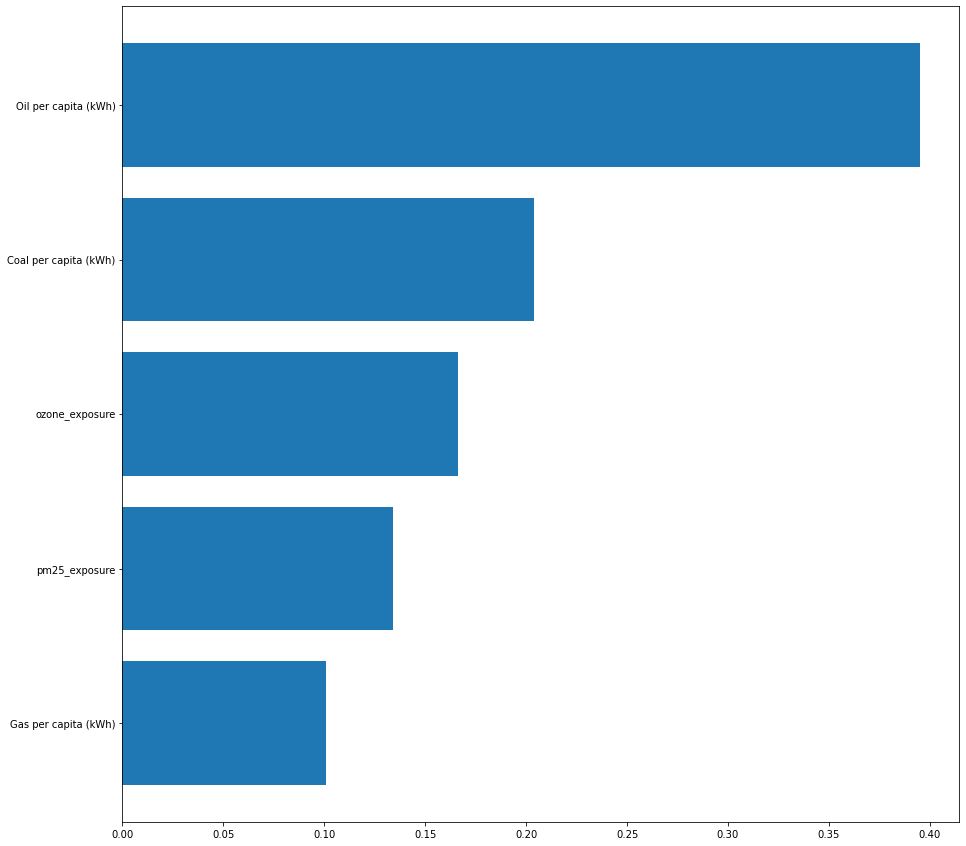

In [259]:
f_i = list(zip(X_norm.columns,forest_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1])
fig, ax = plt.subplots(figsize=(15, 15))
ax.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.savefig("predict-featurecompare.png")
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix
forest_regressor.score(X_test, list(y_test))
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

-0.6680056660114428

In [103]:
#Import scikit-learn metrics module for accuracy calculation


In [121]:
add_to_compare('Random Forest', forest_regressor)

In [106]:
# The coefficients
# print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 14.21
Coefficient of determination: 0.78


In [107]:
# KNN
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
rmse_val = [] #to store rmse values for different k
for K in range(1, 101):
    # K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_norm, y_train)  #fit the model
    pred=model.predict(X_test_norm) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    if K % 2==0:
        print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  2 is: 3.138257790898491
RMSE value for k=  4 is: 3.520086116278775
RMSE value for k=  6 is: 3.7673660168367444
RMSE value for k=  8 is: 3.8945132848158295
RMSE value for k=  10 is: 4.196521595344763
RMSE value for k=  12 is: 4.41018835237676
RMSE value for k=  14 is: 4.599641748824273
RMSE value for k=  16 is: 4.593329584351598
RMSE value for k=  18 is: 4.782695036563022
RMSE value for k=  20 is: 4.840309870309782
RMSE value for k=  22 is: 4.970658477623699
RMSE value for k=  24 is: 5.0143578905257575
RMSE value for k=  26 is: 5.100164169722624
RMSE value for k=  28 is: 5.1430277324171705
RMSE value for k=  30 is: 5.204290532371333
RMSE value for k=  32 is: 5.273764778299349
RMSE value for k=  34 is: 5.309269495990363
RMSE value for k=  36 is: 5.318394216502354
RMSE value for k=  38 is: 5.361278651491075
RMSE value for k=  40 is: 5.4111586891678325
RMSE value for k=  42 is: 5.467044801957158
RMSE value for k=  44 is: 5.509758374694399
RMSE value for k=  46 is: 5.5335

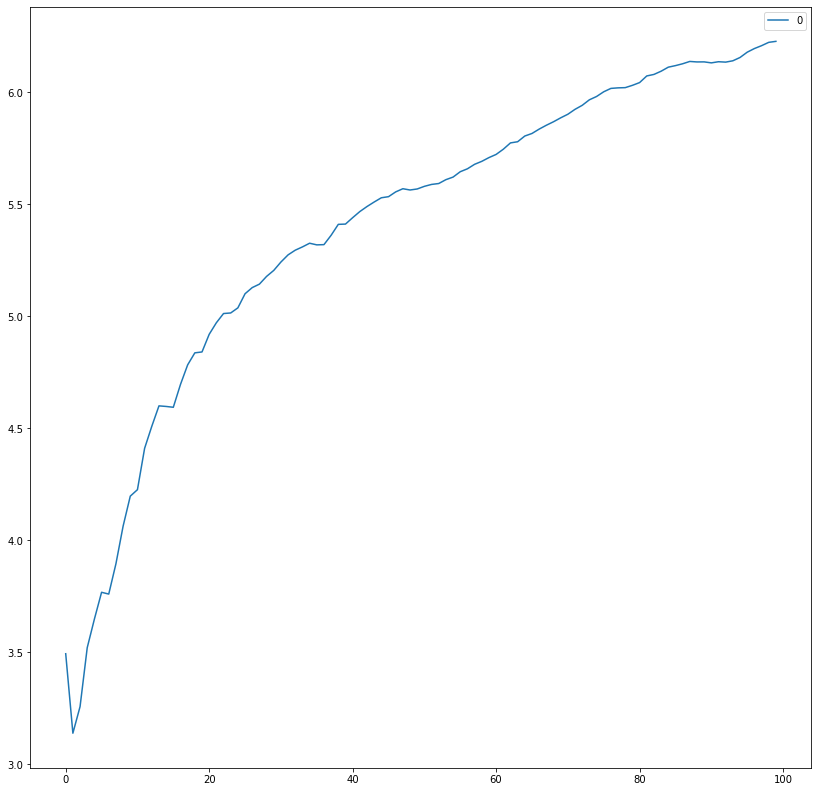

In [255]:
#plotting the rmse values against k values

curve = pd.DataFrame(rmse_val) #elbow curve 
p = curve.plot(figsize=(14, 14))
plt.savefig("predict-knn-best.png")
plt.show()

In [110]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
print("bets param", model.best_params_)


bets param {'n_neighbors': 2}


In [112]:
# y_pred = model.predict(X_test_norm)
# metrics.accuracy_score(y_test, y_pred)
model.score(X_test_norm, y_test)


In [122]:
add_to_compare("KNN", model)

In [116]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
tree = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
tree.fit(X_norm, y_train)

DecisionTreeRegressor(random_state=0)

In [117]:
tree.score(X_test_norm, y_test)

0.49407214165825486

In [123]:
add_to_compare("Tree", tree)

In [124]:
from sklearn.svm import SVR
svm = SVR(kernel = 'rbf')
svm.fit(X_norm, y_train)

SVR()

In [126]:
add_to_compare("SVM", svm)
svm.score(X_test_norm, y_test)

0.467497746266754

In [127]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(X_norm, y_train)

ValueError: Unknown label type: 'continuous'

In [143]:
compare_df = pd.DataFrame(compare_algo, columns=['algorithm', 'error'])
compare_df.head()

,algorithm,error
0,Random Forest,14.212010
1,KNN,108.067517
2,Tree,32.403307
3,SVM,34.105325


In [369]:
fig = px.bar(compare_df, x='algorithm', y='error')

fig.update_layout(
    title="Compare Mean Sqrt Erro"
)
fig.write_html("predict-model-error.html")
fig.show()

In [370]:
X_test_norm

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
442,1.000000,0.847619,0.084019,0.009375,0.001374
281,0.147962,0.121429,0.000000,0.044091,0.001036
332,0.009715,0.266667,0.823598,0.086738,0.013475
126,0.099944,0.197619,0.018093,0.029845,0.000775
941,0.153546,0.066667,0.000000,0.105471,0.463904
...,...,...,...,...,...
780,0.180346,0.435714,0.365987,0.058527,0.017645
997,0.286432,0.616667,0.009032,0.013863,0.065186
316,0.046678,0.552381,0.069888,0.100199,0.021603
843,0.609157,0.700000,0.000330,0.328983,0.104333


In [371]:
iran_test = dataset[dataset.iso_code=="IRN"].iloc[:, 3:]
iran_test.head()

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
462,37.8,53.6,146.563,10403.922,4044.731
463,38.1,53.0,195.384,12191.557,5186.599
464,39.7,55.2,231.012,12341.854,9057.941
465,38.4,52.6,259.493,13524.392,13911.152
466,41.4,51.6,202.719,13500.991,19574.789


In [372]:

iran_test = dataset[dataset.iso_code=="IRN"]

In [373]:
# increase each valu by 1.1
for i in range(5):


    last_row = iran_test.iloc[-1]
    last_row_dict = last_row.to_dict()
    values = last_row[3:] * 1.1
    # iran_test.append()
    last_row_dict.update(values.to_dict())
    last_row_dict.update({"year": last_row.year + 1})
    iran_test = iran_test.append(last_row_dict, ignore_index=True)
    # print(last_row_dict)


In [374]:
iran_test

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,IRN,1990,9.273202,37.80000,53.600000,146.563000,10403.922000,4044.731000
1,IRN,1995,9.887228,38.10000,53.000000,195.384000,12191.557000,5186.599000
2,IRN,2000,10.614775,39.70000,55.200000,231.012000,12341.854000,9057.941000
3,IRN,2005,10.318363,38.40000,52.600000,259.493000,13524.392000,13911.152000
4,IRN,2010,10.203110,41.40000,51.600000,202.719000,13500.991000,19574.789000
5,IRN,2011,10.093052,42.60000,51.500000,222.407000,13621.446000,20525.589000
6,IRN,2012,10.120147,41.50000,53.200000,172.990000,13752.862000,20194.024000
7,IRN,2013,10.317691,41.20000,54.500000,218.168000,14806.560000,20113.833000
8,IRN,2014,10.522132,39.90000,54.800000,245.412000,13613.434000,22384.153000
9,IRN,2015,10.823743,40.90000,55.700000,231.253000,11938.087000,23444.381000


In [375]:
iran_test.iloc[:, 3:]

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,37.80000,53.600000,146.563000,10403.922000,4044.731000
1,38.10000,53.000000,195.384000,12191.557000,5186.599000
2,39.70000,55.200000,231.012000,12341.854000,9057.941000
3,38.40000,52.600000,259.493000,13524.392000,13911.152000
4,41.40000,51.600000,202.719000,13500.991000,19574.789000
5,42.60000,51.500000,222.407000,13621.446000,20525.589000
6,41.50000,53.200000,172.990000,13752.862000,20194.024000
7,41.20000,54.500000,218.168000,14806.560000,20113.833000
8,39.90000,54.800000,245.412000,13613.434000,22384.153000
9,40.90000,55.700000,231.253000,11938.087000,23444.381000


In [376]:
iran_test_nrom = norm(iran_test.iloc[:, 3:])
iran_test_nrom.head()

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,0.000000,0.051090,0.000000,0.000000,0.000000
1,0.012821,0.036493,0.368345,0.166208,0.028988
2,0.081199,0.090015,0.637151,0.180182,0.127269
3,0.025642,0.026761,0.852034,0.290130,0.250476
4,0.153850,0.002433,0.423686,0.287954,0.394258


In [377]:
tree.predict(iran_test_nrom)

array([14.00108905,  2.34825624,  6.04245624,  2.49711416,  4.81919396,
        4.81919396,  4.81919396,  7.94866586,  6.04245624, 16.92156156,
        6.04245624,  4.81911159,  2.49711416,  1.64175321,  3.53176857,
        3.53176857,  3.53176857,  4.46466569,  4.46466569])

In [378]:
real_data = {
    "Real": list(dataset[dataset.iso_code=="IRN"].val.values),
    "Year": list(dataset[dataset.iso_code=="IRN"].year.values)
    }
iran_real_df = pd.DataFrame.from_dict(real_data)

In [379]:
years = list(iran_test.year)
iran_test_model = {"Year": years}


In [380]:
iran_test_model.update({"Forest": forest_regressor.predict(iran_test_nrom)})
iran_test_model.update({"KNN": model.predict(iran_test_nrom)})
iran_test_model.update({"Tree": tree.predict(iran_test_nrom)})
iran_test_model.update({"SVM": svm.predict(iran_test_nrom)})

In [381]:
iran_test_df = pd.DataFrame.from_dict(iran_test_model, )
iran_test_df.head()

,Year,Forest,KNN,Tree,SVM
0,1990,13.703283,18.328136,14.001089,2.903053
1,1995,2.340526,18.328136,2.348256,0.750882
2,2000,8.582735,18.328136,6.042456,2.920799
3,2005,3.018782,18.328136,2.497114,3.481919
4,2010,7.890656,18.328136,4.819194,5.399097


In [382]:
iran_test_df.columns[1:]

Index(['Forest', 'KNN', 'Tree', 'SVM'], dtype='object')

In [384]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=iran_real_df.Year,
        y=iran_real_df.Real,
        mode="lines",
        name='Real',
    ))

for col in iran_test_df.columns[1:]:
    fig.add_trace(
        go.Scatter(
            x=iran_test_df.Year,
            y=iran_test_df[col],
            mode="lines",
            name=col,
            line=dict(width=2, dash="dot"),
        )
    )

fig.update_layout(
    title="Real Death rate vs Estimated With Various model for Iran",
    xaxis_title= "Year",
    yaxis_title="Death Rate"
)
fig["layout"]["hovermode"] = "x"
fig.write_html("predict-model-predict.html")
fig.show()
